In [13]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pathlib
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, MaxPool2D, Flatten


In [14]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [15]:
# Defining the path for train and test images

In [16]:
test_path = "/content/gdrive/MyDrive/Test"

In [17]:
train_path = "/content/gdrive/MyDrive/Train"

In [18]:
train_dir = pathlib.Path(train_path)
test_dir = pathlib.Path(test_path)

In [19]:
# Count of images in train directory and test directory

In [20]:
train_count = len(list(train_dir.glob('*/*.jpg')))
train_count

2239

In [21]:
test_count = len(list(test_dir.glob('*/*.jpg')))
test_count

118

# Split the Train dataset for Training and Valiation

### Splitting 80% of Training data set for training the model and 20% for validating the model

In [22]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(train_dir, seed = 156, validation_split = 0.2,
                                                              image_size = (180, 180),
                                                              subset = 'training',
                                                              batch_size = 32,
                                                              color_mode = 'rgb')

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


In [23]:
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(train_dir, seed=156, validation_split=0.2,
                                                            image_size = (180, 180),
                                                            subset='validation',
                                                            batch_size = 32,
                                                            color_mode = 'rgb')

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


### Data Visualisation

In [24]:
class_names = train_dataset.class_names
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [25]:
image = plt.imread((list(train_dir.glob(class_names[6] + '/*.jpg'))[0]))

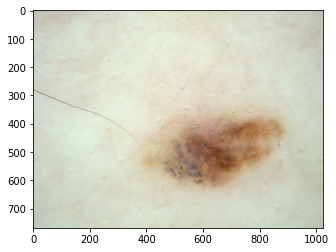

In [26]:
plt.imshow(image)

### Visualising one instance of all classes present in the dataset


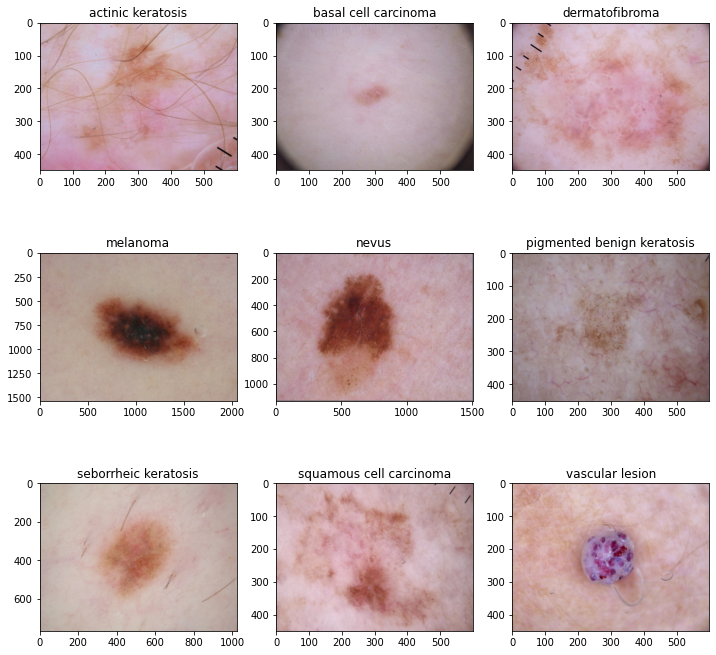

In [27]:
plt.figure(figsize=(12,12))
for i in range(9):
  plt.subplot(3, 3, i+1)
  image= plt.imread(str(list(train_dir.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

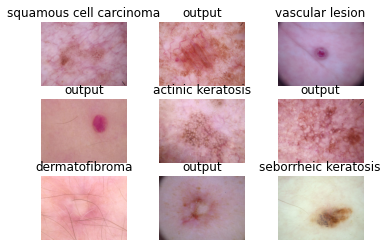

In [28]:
i = 0
for dirpath, dirnames, filenames in os.walk(str(train_path)):
  for filename in [name for name in filenames if name.endswith(".jpg")][:1]:
    if i <= 8:
      img = PIL.Image.open(str(dirpath) + "/" + str(filename))
      plt.subplot(3, 3, i + 1)
      plt.title(str(dirpath).split('/')[-1])
      plt.axis('off')
      plt.imshow(img)
      i = i + 1

cache() helps to keep the images in disk after loaded off for the first epoch.

prefetch() helps to parralelise data preprocessing and mode execution which training

In [29]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

# Model Building

## The Model
- The input to the network is an image of dimensions (180, 180, 3). 
- The first two layers have 32 channels of a 3*3 filter size and the same padding. 
- Max pool layer of stride (2, 2), 
- All the hidden layers use ReLU as its activation function as it is more computationally efficient.
- Then we flatten this output. After this there is a fully connected layer. which is used to implement softmax function to classify 9 classes. 
- Dropout of 0.2 is used to minimise the overfitting.

In [30]:
model = Sequential([tf.keras.layers.experimental.preprocessing.Rescaling(1/255,
                                                                       input_shape=(180, 180, 3),
                                                                       offset=0.0)])

model.add(Conv2D(filters=32, kernel_size= (3,3), activation='relu', padding='same', input_shape=(180, 180, 3)))
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(9, activation='softmax'))


## Compile Model

In [31]:
model.compile(optimizer = 'adam', metrics=['accuracy'],
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True))

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 90, 90, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        9248      
                                                        

We have
- Total params: 1,067,337
- Trainable params: 1,067,337
- Non-trainable params: 0

## Training Model

In [33]:
epochs= 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


281/281 [==============================] - 4097s 3s/step - loss: 1.9736 - accuracy: 0.2142 - val_loss: 1.9407 - val_accuracy: 0.2185
Epoch 2/20
281/281 [==============================] - 17s 60ms/step - loss: 1.6313 - accuracy: 0.3578 - val_loss: 1.5487 - val_accuracy: 0.3970
Epoch 3/20
281/281 [==============================] - 17s 60ms/step - loss: 1.4077 - accuracy: 0.4543 - val_loss: 1.2758 - val_accuracy: 0.5162
Epoch 4/20
281/281 [==============================] - 17s 60ms/step - loss: 1.2014 - accuracy: 0.5410 - val_loss: 1.0899 - val_accuracy: 0.5821
Epoch 5/20
281/281 [==============================] - 17s 60ms/step - loss: 1.0468 - accuracy: 0.6041 - val_loss: 0.8682 - val_accuracy: 0.6689
Epoch 6/20
281/281 [==============================] - 17s 61ms/step - loss: 0.8695 - accuracy: 0.6760 - val_loss: 0.7595 - val_accuracy: 0.7405
Epoch 7/20
281/281 [==============================] - 17s 61ms/step - loss: 0.7368 - accuracy: 0.7244 - val_loss: 0.7611 - val_accuracy: 0.7441
Epo

## Visualising Results

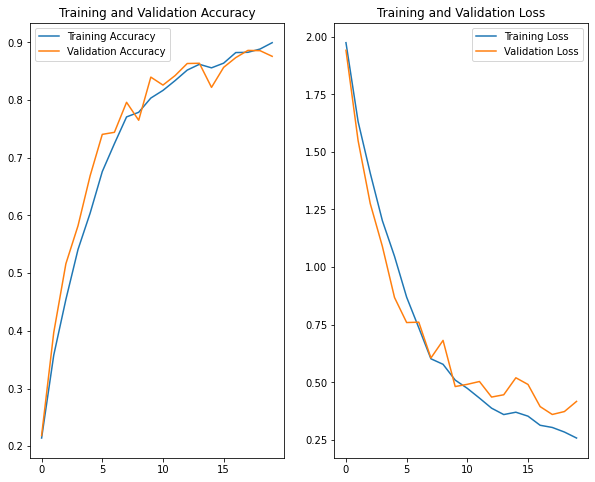

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


## Key Observations
* Validation Accuracy is much lesser than Training accuracy.
* Training accuracy is around 85%
* Validation accuracy is around 81% and tending downwards
* This shows that model is kind of overfitting.
* The training accuracy increases with increase in epochs. 
* But validation accuracy seems to be stable and obviously decreases with increase in epochs as model may tend to overfit.
* Validation loss and training loss seems to be same till 10 epochs approx and then validation loss increases and training loss further decreases with increase in epochs which is eexpected.





In [37]:
# Lets check how images are distributed in different classed in training dataset
for i in range(len(class_names)):
  class_name = class_names[i]
  count = str(len(list(train_dir.glob(class_names[i] + '/*.jpg'))))
  print(class_name + " - " + count)


actinic keratosis - 114
basal cell carcinoma - 376
dermatofibroma - 95
melanoma - 438
nevus - 357
pigmented benign keratosis - 462
seborrheic keratosis - 77
squamous cell carcinoma - 181
vascular lesion - 139


In [38]:
# Lets check how images are distributed in different classed in test dataset
for i in range(len(class_names)):
  class_name= class_names[i]
  count = str(len(list(test_dir.glob(class_names[i]+'/*.jpg'))))
  print(class_name + " - " + count)


actinic keratosis - 16
basal cell carcinoma - 16
dermatofibroma - 16
melanoma - 16
nevus - 16
pigmented benign keratosis - 16
seborrheic keratosis - 3
squamous cell carcinoma - 16
vascular lesion - 3


## Potential Problems 

- Uneven dataset: In Training dataset the distribution of images are uneven.
  - seborrheic keratosis - 77
  - squamous cell carcinoma - 181
  - vascular lesion - 139
  - actinic keratosis - 114

- The samples in above cases are very less in comparison to 
the other cases. 

- So we need to increase sampled in each of the above case.

- We will use Data Augmentation and Augmentor



# Data Augmentation

In [39]:
data_augmentation = tf.keras.Sequential([
                                          layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical"),
                                          layers.experimental.preprocessing.RandomRotation(0.2)
])

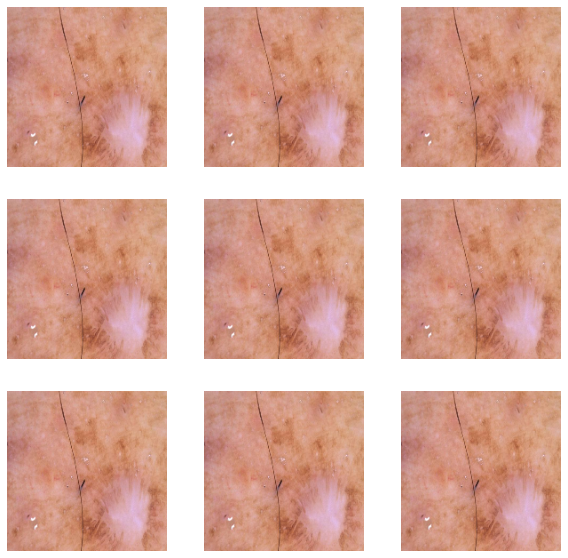

In [40]:
image, label = next(iter(train_ds))
image = np.array(image ,np.int32)  
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  augmented_image1=np.array(augmented_image[0],np.int32)  
  plt.imshow((augmented_image1))
  plt.axis("off")

## Model with Data Augumentation

In [41]:
model=Sequential([data_augmentation,
                  tf.keras.layers.experimental.preprocessing.Rescaling(1/255,
                                                                       input_shape=(180, 180, 3), offset=0.0)])

model.add(Conv2D(filters=32, kernel_size= (3,3), activation='relu', padding='same', input_shape=(180, 180, 3)))
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(9, activation='softmax'))

In [42]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [43]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
281/281 [==============================] - 19s 62ms/step - loss: 1.9783 - accuracy: 0.2101 - val_loss: 1.9430 - val_accuracy: 0.2617
Epoch 2/20
281/281 [==============================] - 18s 63ms/step - loss: 1.6074 - accuracy: 0.3660 - val_loss: 1.5069 - val_accuracy: 0.3970
Epoch 3/20
281/281 [==============================] - 17s 62ms/step - loss: 1.4664 - accuracy: 0.4101 - val_loss: 1.4818 - val_accuracy: 0.3996
Epoch 4/20
281/281 [==============================] - 18s 62ms/step - loss: 1.4127 - accuracy: 0.4446 - val_loss: 1.3637 - val_accuracy: 0.4624
Epoch 5/20
281/281 [==============================] - 18s 63ms/step - loss: 1.3855 - accuracy: 0.4516 - val_loss: 1.3083 - val_accuracy: 0.4851
Epoch 6/20
281/281 [==============================] - 18s 63ms/step - loss: 1.3394 - accuracy: 0.4699 - val_loss: 1.2901 - val_accuracy: 0.4891
Epoch 7/20
281/281 [==============================] - 18s 64ms/step - loss: 1.3261 - accuracy: 0.4815 - val_loss: 1.2585 - val_accuracy:

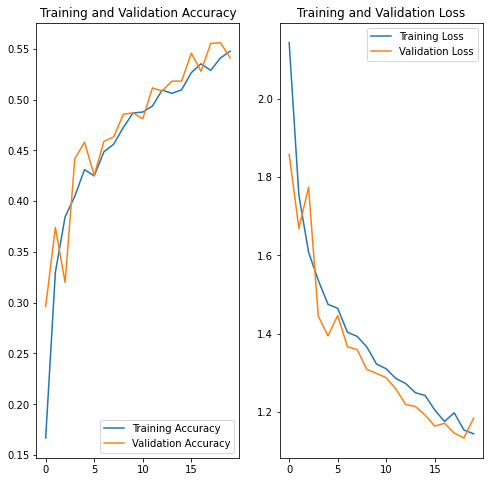

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc ='upper left')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc ='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Key Observations
 - Training accuracy and validation accuracy are almost equal and follow similar trends now.
 - Though the training and testing accuracy are almost equal, the problem of overfitting has been addressed with data augmentation and now both accuracies are tend to be same.
 - Now we have to deal with reduces accuracies.





# Checking for Class Imbalance

In [44]:
# Lets check how images are distributed in different classed in test dataset
for i in range(len(class_names)):
  class_name= class_names[i]
  count = str(len(list(train_dir.glob(class_names[i]+'/*.jpg'))))
  print(class_name +" - "+ count)


actinic keratosis - 114
basal cell carcinoma - 376
dermatofibroma - 95
melanoma - 438
nevus - 357
pigmented benign keratosis - 462
seborrheic keratosis - 77
squamous cell carcinoma - 181
vascular lesion - 139


The training dataset the distribution of images are uneven.


- seborrheic keratosis - 77
- squamous cell carcinoma - 181
- vascular lesion - 139
- actinic keratosis - 114


The samples in above cases are very less in comparison to 
the other cases. So we need to increase the samples in each case.

###  Augmentor for addressing class imbalance problem

In [45]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [46]:
import Augmentor

In [48]:
for i in class_names:
  print(train_path + i)

/content/gdrive/MyDrive/Trainactinic keratosis
/content/gdrive/MyDrive/Trainbasal cell carcinoma
/content/gdrive/MyDrive/Traindermatofibroma
/content/gdrive/MyDrive/Trainmelanoma
/content/gdrive/MyDrive/Trainnevus
/content/gdrive/MyDrive/Trainpigmented benign keratosis
/content/gdrive/MyDrive/Trainseborrheic keratosis
/content/gdrive/MyDrive/Trainsquamous cell carcinoma
/content/gdrive/MyDrive/Trainvascular lesion


In [49]:

training_dataset_path = train_path
for i in class_names:
    p = Augmentor.Pipeline(training_dataset_path + '/' +i)
    p.rotate(probability = 0.7, max_right_rotation = 10, max_left_rotation = 10)
    p.sample(500)
# We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF60636B1D0>: 100%|██████████| 500/500 [00:19<00:00, 25.92 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FF606330710>: 100%|██████████| 500/500 [00:20<00:00, 24.19 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF69FA51D90>: 100%|██████████| 500/500 [00:19<00:00, 25.02 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7FF60636CED0>: 100%|██████████| 500/500 [01:28<00:00,  5.63 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF6062F1ED0>: 100%|██████████| 500/500 [01:29<00:00,  5.62 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FF60C043150>: 100%|██████████| 500/500 [00:19<00:00, 25.66 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FF60C08E410>: 100%|██████████| 500/500 [00:43<00:00, 11.56 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF60C0B1110>: 100%|██████████| 500/500 [00:20<00:00, 24.76 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF6063A80D0>: 100%|██████████| 500/500 [00:18<00:00, 26.44 Samples/s]


In [50]:
from glob import glob

In [51]:
path_list = [x for x in glob(os.path.join(train_dir, '*','output', '*.jpg'))]

In [52]:
len(path_list)

13500

In [53]:
list_new = [os.path.basename(os.path.dirname(os.path.dirname(dir))) for dir in glob(os.path.join(train_dir, '*','output', '*.jpg'))]

In [55]:
len(list_new)

13500

In [57]:
new_dataframe_dict = dict(zip(path_list, list_new))


In [58]:
len(new_dataframe_dict )

13500

In [60]:
for i in class_names:
    directory = train_path
    directory_out = train_path + '/' + i +'/output/'
    class_directory = pathlib.Path(directory)
    class_directory_out = pathlib.Path(directory_out)
    length = len(list(class_directory.glob(i + '/*.jpg')))
    length_out = len(list(class_directory_out.glob('*.jpg')))
    length_total = length + length_out
    print(f'{i} has {length_total} samples.')

actinic keratosis has 1614 samples.
basal cell carcinoma has 1876 samples.
dermatofibroma has 1595 samples.
melanoma has 1938 samples.
nevus has 1857 samples.
pigmented benign keratosis has 1962 samples.
seborrheic keratosis has 1577 samples.
squamous cell carcinoma has 1681 samples.
vascular lesion has 1639 samples.


### By augmentor the number of sampes in each class has been increased. Now the distribution looks balanced.

# **Model with Augmented Data**

In [61]:
img_height = 180
img_width = 180

In [62]:
data_dir_train=train_path
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, seed = 156, label_mode='categorical', validation_split = 0.2,
                                                               subset = 'training', image_size = (img_height, img_width), batch_size=32)

Found 15739 files belonging to 9 classes.
Using 12592 files for training.


In [63]:
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, seed = 156, label_mode='categorical', validation_split = 0.2,
                                                                  subset = 'validation', image_size=(img_height, img_width), batch_size=32)

Found 15739 files belonging to 9 classes.
Using 3147 files for validation.


In [64]:
model=Sequential([tf.keras.layers.experimental.preprocessing.Rescaling(1/255,
                                                                       input_shape = (180, 180 ,3),
                                                                       offset = 0.0)])

model.add(Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', padding = 'same', input_shape = (180, 180, 3)))
model.add(Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 32,kernel_size = (3,3),activation = 'relu', padding = 'same'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 64,kernel_size = (3,3), activation = 'relu', padding = 'same'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding = 'same'))
model.add(MaxPool2D(pool_size =( 2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(9, activation = 'softmax'))


In [65]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [68]:
tf.config.run_functions_eagerly(True)
history = model.fit(train_dataset, validation_data = val_dataset, epochs=25)

Epoch 1/25
394/394 [==============================] - 81s 199ms/step - loss: 2.1895 - accuracy: 0.1294 - val_loss: 2.1018 - val_accuracy: 0.1471
Epoch 2/25
394/394 [==============================] - 70s 176ms/step - loss: 1.6867 - accuracy: 0.3478 - val_loss: 1.5434 - val_accuracy: 0.4175
Epoch 3/25
394/394 [==============================] - 72s 179ms/step - loss: 1.2757 - accuracy: 0.5121 - val_loss: 1.0791 - val_accuracy: 0.5999
Epoch 4/25
394/394 [==============================] - 70s 176ms/step - loss: 1.0158 - accuracy: 0.6217 - val_loss: 0.9419 - val_accuracy: 0.6454
Epoch 5/25
394/394 [==============================] - 72s 180ms/step - loss: 0.7988 - accuracy: 0.6993 - val_loss: 0.7022 - val_accuracy: 0.7563
Epoch 6/25
394/394 [==============================] - 70s 176ms/step - loss: 0.6757 - accuracy: 0.7515 - val_loss: 0.6683 - val_accuracy: 0.7461
Epoch 7/25
394/394 [==============================] - 72s 181ms/step - loss: 0.5410 - accuracy: 0.7985 - val_loss: 0.6020 - val_ac

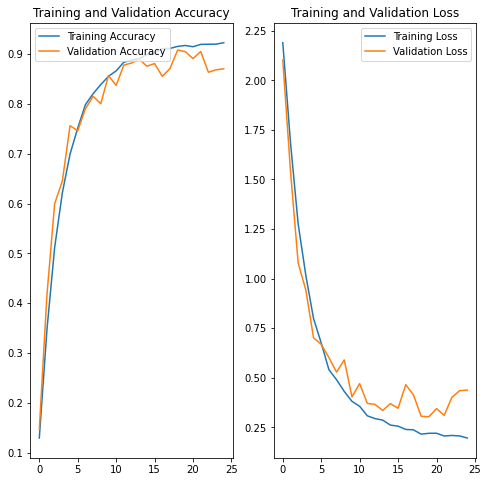

In [69]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs=25
epochs_range =range(epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Conclusion
- The accuracy of test set is around 90%
- Accuracy of validation dats set is around 87%
- We may run extra epochs to see if the model performs better. But, in such case there could be a problem of overfitting as well.
- The model with the above accuracy shows an increased performace of the model when we train with dataset where number of images in each class is balanced.
- We can see that the model performed better on augmented data. 
- Even there is no much significant difference in training loss and validation loss as well and they tend to follow same trend.